In [ ]:
%pip install bokeh
%pip install jupyter_bokeh

In [5]:
import requests
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from collections import deque

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

# Utils

In [2]:

def polynomialRegression(dataframe, column, order):
    indexs_2 = np.array([i for i in range(len(dataframe[column].values))])
    indexs_2 = np.reshape(indexs_2, newshape=(1,-1))[0]

    RMSEs = []
    for i in range(order):
        features = PolynomialFeatures(degree=i+1)
        x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
        
        model = LinearRegression().fit(x_train_transformed, dataframe[column].values)

        train_pred = model.predict(x_train_transformed)
        rmse_poly_4_train = mean_squared_error(dataframe[column].values, train_pred, squared = False)
        RMSEs.append(rmse_poly_4_train)

    features = PolynomialFeatures(degree=RMSEs.index(min(RMSEs))+1)
    x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
    model = LinearRegression().fit(x_train_transformed, dataframe[column].values)

    x_test_transformed = features.fit_transform(indexs_2.reshape(-1, 1))

    train_pred = model.predict(x_train_transformed)

    test_pred = model.predict(x_test_transformed)
    
    dataframe[f'Poly_{column}'] = test_pred
    return test_pred        

# OHLCV Data

## Loading the data

In [3]:
from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope, computeSuperTrend

SYMBOL= 'AVAX'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df.head()

,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2021-03-05 11:00:00,20.000,29.900,20.000,24.389,2269.338842,1614938400
2021-03-05 12:00:00,24.382,24.927,24.382,24.927,644.195305,1614942000
2021-03-05 13:00:00,24.938,25.465,24.500,24.734,1803.342134,1614945600
2021-03-05 14:00:00,25.000,25.445,24.892,25.445,285.892382,1614949200
2021-03-05 15:00:00,25.271,26.000,24.967,25.011,501.201474,1614952800


In [6]:
df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,High_Low_diff,EMA20,EMA50,EMA100,...,Stoch_RSI,Vortex,Bollinger_low,Bollinger_high,ADX,ATR,CCI,OVB,OVB_EMA200,EVM
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-22 01:00:00,32.768,33.313,31.211,31.381,2555.444076,1616371200,2.102,33.255894,34.179881,34.145417,...,0.000000,-0.121333,34.628379,31.732821,16.764642,21.913451,-196.178451,32654.206005,17737.232185,-46433.377713
2021-03-22 02:00:00,31.394,31.691,31.113,31.413,783.389096,1616374800,0.578,33.080380,34.071376,34.091310,...,0.023070,-0.217147,34.530942,31.519758,16.678501,20.998973,-217.132744,33437.595100,17893.454702,-63452.504360
2021-03-22 03:00:00,31.512,32.052,31.394,31.926,508.536342,1616378400,0.658,32.970439,33.987243,34.048432,...,0.385854,-0.240960,34.222824,31.540776,16.096226,20.131706,-141.550849,33946.131442,18053.182828,41534.494729
2021-03-22 04:00:00,31.875,34.578,31.858,32.240,1088.918812,1616382000,2.720,32.900874,33.918724,34.012622,...,0.593317,-0.082439,33.991471,31.570929,16.774555,20.244622,-4.367426,35035.050254,18222.156634,373434.635748
2021-03-22 05:00:00,32.436,33.736,32.297,32.750,751.461416,1616385600,1.439,32.886505,33.872892,33.987620,...,0.908128,-0.066133,33.974742,31.562558,17.404431,20.352406,4.950237,35786.511670,18396.926336,-38585.946489


In [7]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM'],
      dtype='object')

## Plotting some graphs

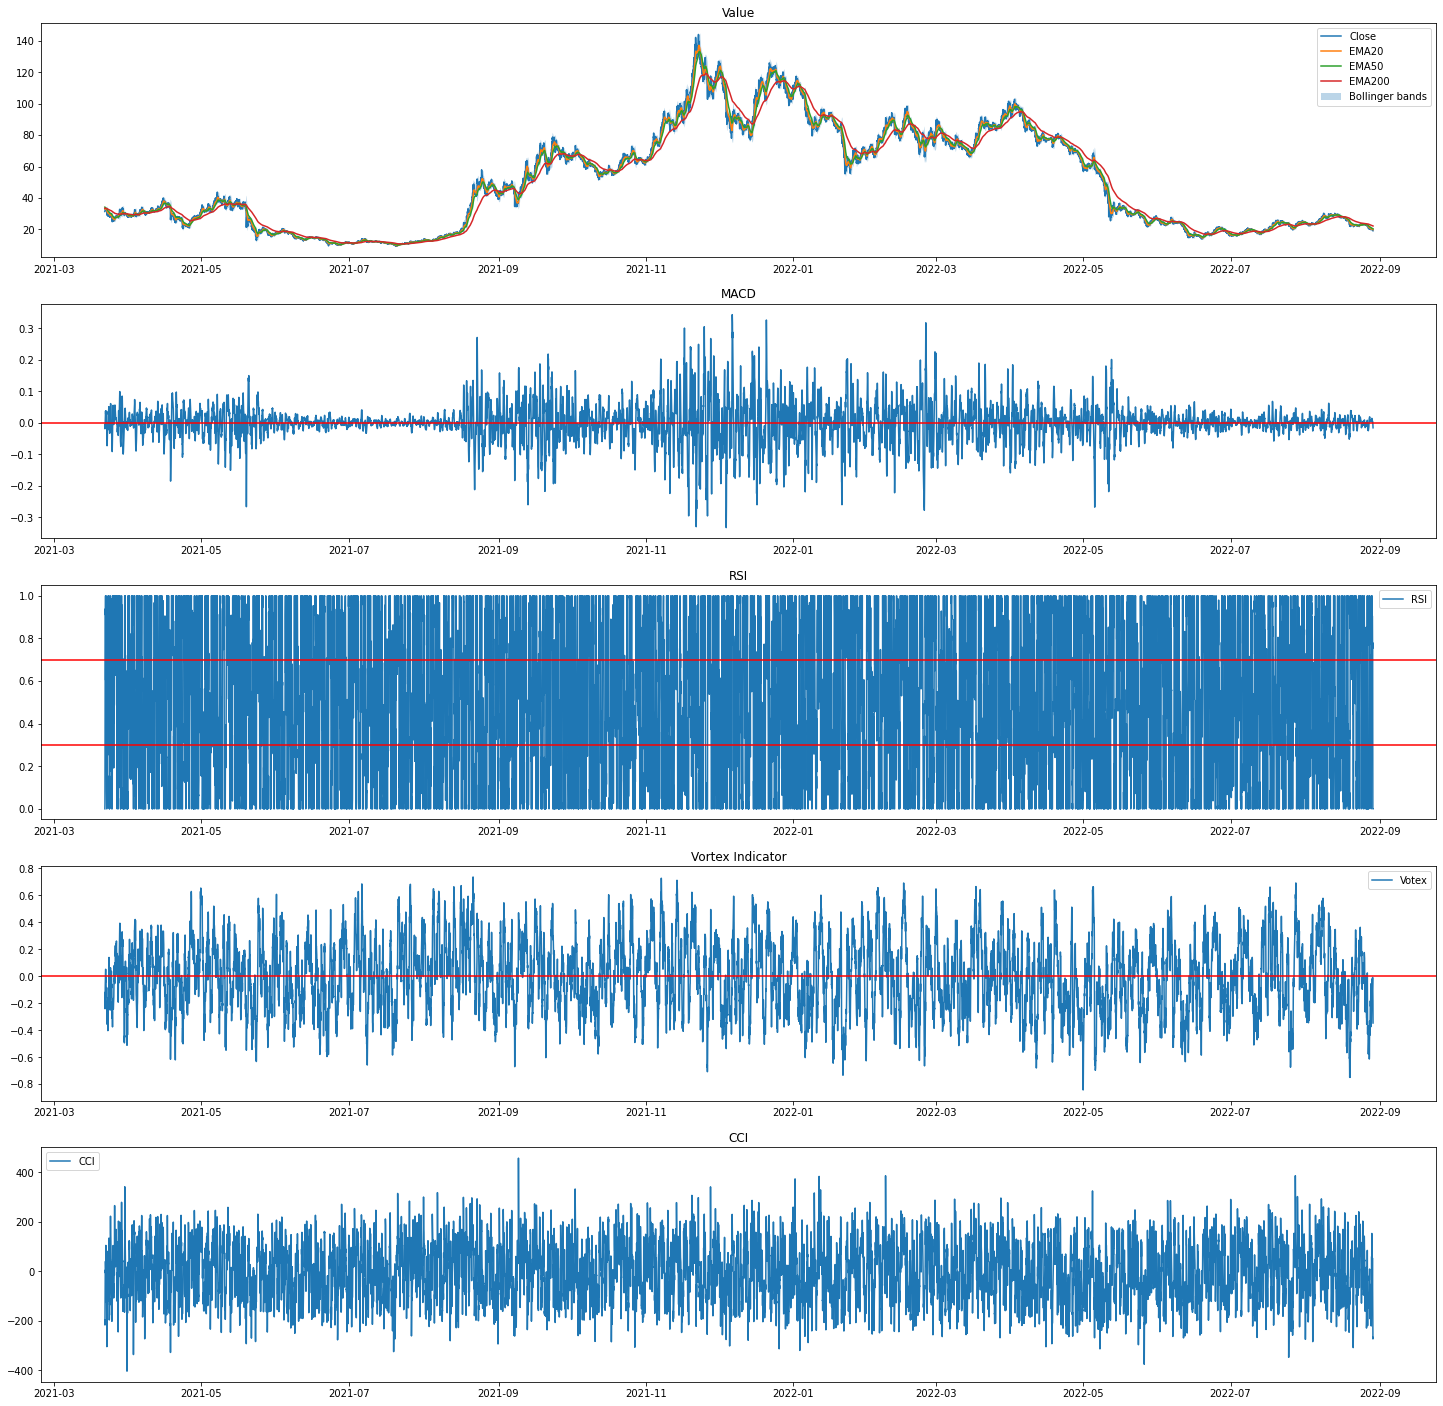

In [10]:
fig, ax1 = plt.subplots(5, 1,figsize=(25,25))
#fig.suptitle(f'Close')
ax1[0].plot(df.Close, label='Close')
ax1[0].plot(df.EMA20, label='EMA20')
ax1[0].plot(df.EMA50, label='EMA50')
ax1[0].plot(df.EMA200, label='EMA200')
ax1[0].fill_between(df.index, df.Bollinger_low,df.Bollinger_high, label='Bollinger bands',alpha=0.3)
ax1[0].legend(loc="upper right")
ax1[0].set_title(f'Value')
ax1[2].plot(df.Stoch_RSI, label='RSI')
ax1[2].axhline(y=0.70, color='r', linestyle='-')
ax1[2].axhline(y=0.30, color='r', linestyle='-')
ax1[2].set_title(f'RSI')
ax1[2].legend(loc="upper right")
ax1[1].plot(df.MACD, label='MACD_diff')
ax1[1].axhline(y=0, color='r', linestyle='-')
ax1[1].set_title(f'MACD')
ax1[3].plot(df['Vortex'], label='Votex')
ax1[3].axhline(y=0, color='r', linestyle='-')
ax1[3].set_title(f'Vortex Indicator')
ax1[3].legend(loc="upper right")
ax1[4].plot(df.CCI, label='CCI')
ax1[4].set_title(f'CCI')
ax1[4].legend(loc="upper left")

## Prediction with tensorflow

### Classical one day prediction

In [ ]:
%pip install tensorflow_decision_forests --upgrade

Import all important packages

In [11]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, GRU, InputLayer, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.activations import relu
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy

2022-08-29 17:56:50.033304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 17:56:50.033328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Let's see the distribution of all columns to adjust the normalization procedure.

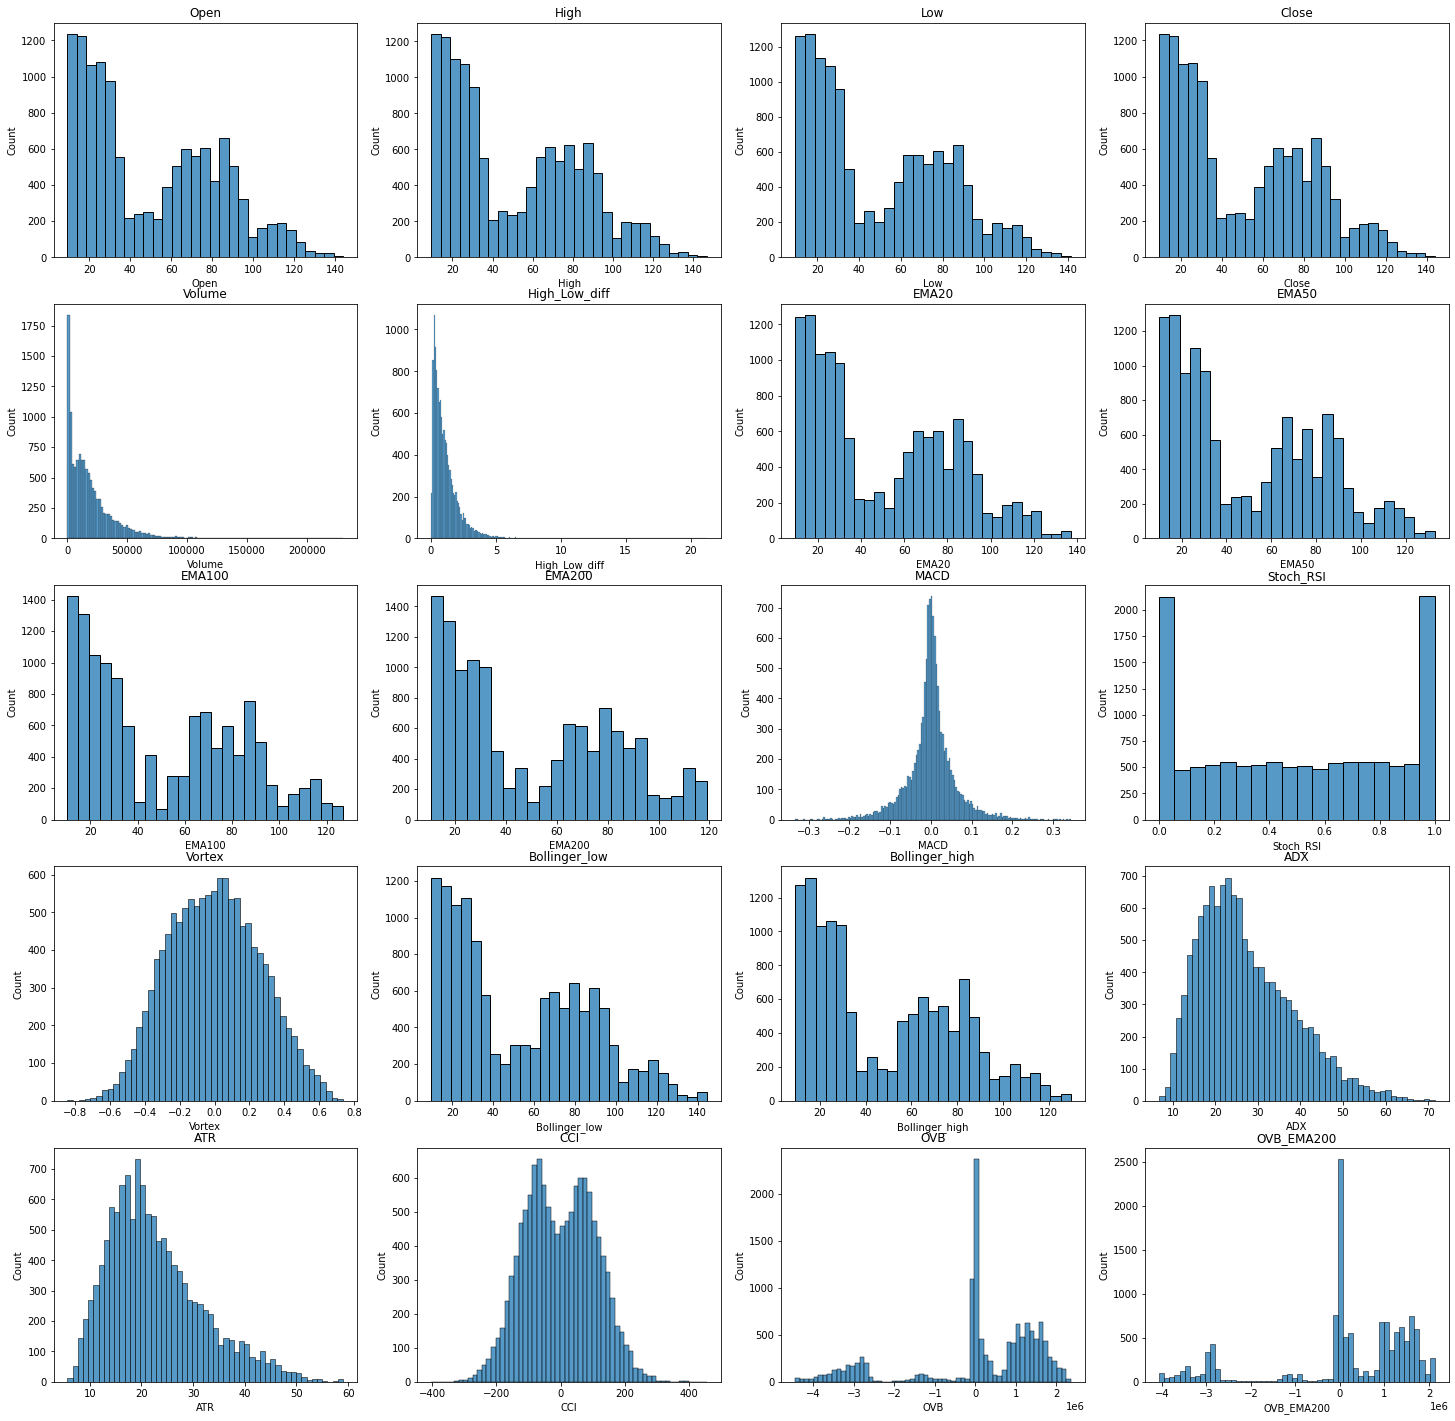

In [14]:
import seaborn as sns

df_i = df.drop(['Timestamp'],axis='columns')
n_rows=5
n_cols=4
# Create the subplots
#fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
    
    
fig, axes = plt.subplots(nrows = 5, ncols = 4,figsize=(25,25))    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(25, 25)

for ax, col in zip(axes, df_i.columns):
  sns.histplot(df_i[col], ax = ax)
  ax.set_title(col)

In [ ]:
import tensorflow_decision_forests as tfdf

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df, label="close")

# Train the model
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

In [ ]:
# Look at the model.
model.summary()

# Evaluate the model.
model.evaluate(test_ds)

In [16]:
class ModelCrypto:
  def __init__(self, WINDOW_SIZE=10,metric="EMA20",features=['Open', 'High', 'Low', 'Close', 'Volume', 'High_Low_diff',
                                                'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
                                                'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
                                                'OVB_EMA200', 'EVM']):

    self._offset_prediction = 0
    self._WINDOW_SIZE = WINDOW_SIZE
    self._metric = metric
    self._features = features
    
    self._model = Sequential()
    self._model.add(InputLayer((WINDOW_SIZE, len(features))))
    self._model.add(LSTM(units = 64, return_sequences = True))
    self._model.add(LSTM(units = 32, return_sequences = True))
    for dilation_rate in (1,2,4,8,16,23):
      self._model.add(Conv1D(filters=32,kernel_size=2,dilation_rate=dilation_rate,strides=1,padding='causal',activation=keras.activations.relu))
    self._model.add(Conv1D(filters=1,kernel_size=1)) 
    self._model.add(Flatten())
    self._model.add(Dropout(0.2))
    self._model.add(Dense(units = 10,activation=keras.activations.relu))
    self._model.add(Dense(units = 5,activation=keras.activations.relu))
    self._model.add(Dense(units = 1,activation=keras.activations.linear))

    self._model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mean_squared_error',metrics=[RootMeanSquaredError()])
    

    self._featuresScaler = StandardScaler()
    self._labelsScaler = StandardScaler()

  def trainModel(self,df_i):
    X_train, y_train, featuresScaler, labelsScaler = self.scaleAndConstructData(df_i)

    history = self._model.fit(X_train, y_train, epochs=15,validation_split=0.2,shuffle=True,batch_size=16)
    fig, ax1  = plt.subplots(1, 1,figsize=(15,4))
    ax1.plot(history.history['root_mean_squared_error'],label='Loss')
    ax1.plot(history.history['val_root_mean_squared_error'],label=f'Validation Loss')
    ax1.legend(loc='upper left')
      

  def scaleAndConstructData(self, dataframe):
    featuresScaler = StandardScaler()
    labelsScaler = StandardScaler()
    scaled_labels = labelsScaler.fit_transform(dataframe[[self._metric]])
    scaled_features = featuresScaler.fit_transform(dataframe[self._features])

    X_train = [scaled_features[i-self._WINDOW_SIZE:i,:] for i in range(self._WINDOW_SIZE, len(scaled_features)-2)]
    y_train = [scaled_labels[i+2] for i in range(self._WINDOW_SIZE, len(scaled_features)-2)]

    return np.array(X_train), np.array(y_train), featuresScaler, labelsScaler

  def evaluateModel(self, df_test):
    X_test, y_test, featuresScaler, labelsScaler = self.scaleAndConstructData(df_test)
    print('model\'s score : ',self._model.evaluate(X_test, y_test,batch_size=32))
    
    y_test_predicted = self._model.predict(X_test)

    y_test_predicted_inv = labelsScaler.inverse_transform(y_test_predicted)
    y_test_real_inv = labelsScaler.inverse_transform(y_test)
    y_test_real_inv = [y_test_real_inv[i][0] for i in range(len(y_test_real_inv))]
    y_test_predicted_inv = [y_test_predicted_inv[i][0] for i in range(len(y_test_predicted_inv))]

    p = figure(title=f"Prediction on {self._metric}", x_axis_label='time', y_axis_label='value ($)',x_axis_type='datetime',width=1500, height=600,)
    # Add the HoverTool to the figure
    p.add_tools(HoverTool(
        tooltips=[
        ("Price", "@y{0.00} $"),
        ("Date", "$x{%F}"),
    ], formatters={
            '$x': 'datetime',
            '$y' : 'printf',
        },
        mode='vline'
    ))
    p.line(df_test.index, y_test_real_inv, legend_label="real data", line_width=2, )
    p.line(df_test.index, y_test_predicted_inv, legend_label="prediction data", line_width=2, color='orange')
    p.legend.location = "top_left"

    show(p)
    
  def getModel(self):
    return self._model
    
  def saveModel(self, path='./model.h5'):
    self._model.save(path)

2022-08-29 17:59:05.218147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-29 17:59:05.218191: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-29 17:59:05.218215: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (baptiste-ThinkPad-T470): /proc/driver/nvidia/version does not exist
2022-08-29 17:59:05.219047: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15


2022-08-29 17:59:06.889411: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36115200 exceeds 10% of free system memory.


627/627 [==============================] - 48s 65ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1836
Epoch 2/15
627/627 [==============================] - 39s 63ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 3/15
627/627 [==============================] - 50s 79ms/step - loss: 0.0147 - root_mean_squared_error: 0.1214 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 4/15
627/627 [==============================] - 43s 68ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1348
Epoch 5/15
627/627 [==============================] - 44s 71ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 6/15
627/627 [==============================] - 42s 67ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0163 - val

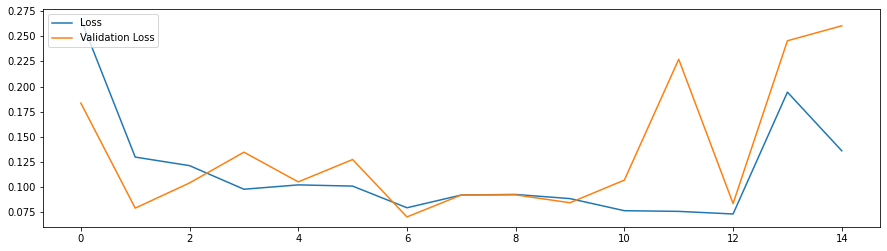

In [17]:
crypto_model = ModelCrypto(50,features=['Close', 'Volume', 'High_Low_diff',
                                        'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
                                        'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
                                        'OVB_EMA200', 'EVM'])
crypto_model.trainModel(df)

In [18]:
crypto_model.evaluateModel(df)

  1/392 [..............................] - ETA: 26s - loss: 0.0061 - root_mean_squared_error: 0.0782

2022-08-29 18:12:13.488408: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 45144000 exceeds 10% of free system memory.


392/392 [==============================] - 9s 24ms/step - loss: 0.0204 - root_mean_squared_error: 0.1429
model's score :  [0.0204328540712595, 0.14294353127479553]


2022-08-29 18:12:22.948015: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 45144000 exceeds 10% of free system memory.


### 1D LSTM autoencoder

In [ ]:
class ModelCrypto1DAutoencoder:
  def __init__(self, WINDOW_SIZE=10,metric="close"):

    self._offset_prediction = 0
    self._WINDOW_SIZE = WINDOW_SIZE
    self._metric = metric
    #self._features = features
    
    #self._model = Sequential()
    #self._model.add(InputLayer((WINDOW_SIZE, 1)))
    #self._model.add(LSTM(units = 64, return_sequences = True))
    #for dilation_rate in (1,2,4,8,16,23):
    #  self._model.add(Conv1D(filters=32,kernel_size=2,dilation_rate=dilation_rate,strides=1,padding='causal',activation=keras.activations.relu))
    #self._model.add(Conv1D(filters=1,kernel_size=1)) 
    #self._model.add(Flatten())
    #self._model.add(Dropout(0.2))
    #self._model.add(Dense(units = 10,activation=keras.activations.relu))
    #self._model.add(Dense(units = 5,activation=keras.activations.relu))
    #self._model.add(Dense(units = 1,activation=keras.activations.linear))
#
    #self._model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mean_squared_error',metrics=[RootMeanSquaredError()])
    

    
    
    self._model = keras.Sequential()
    self._model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, self._WINDOW_SIZE, 1), return_sequences=True, name='encoder_1'))
    self._model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
    self._model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
    self._model.add(keras.layers.RepeatVector(self._WINDOW_SIZE, name='encoder_decoder_bridge'))
    self._model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
    self._model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
    self._model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
    self._model.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
    self._model.compile(loss="mse",optimizer='adam',metrics=[RootMeanSquaredError()])
    self._model.build()
    #print(self._model.summary())

    self._featuresScaler = StandardScaler()
    self._labelsScaler = StandardScaler()

  def trainModel(self,df_i):
    X_train, y_train, featuresScaler, labelsScaler = self.scaleAndConstructData(df_i)
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)
    history = self._model.fit(X_train, y_train, epochs=20,validation_split=0.2,shuffle=True,batch_size=64,callbacks=[early_stop])
    fig, ax1  = plt.subplots(1, 1,figsize=(15,4))
    ax1.plot(history.history['root_mean_squared_error'],label='Loss')
    ax1.plot(history.history['val_root_mean_squared_error'],label=f'Validation Loss')
    ax1.legend(loc='upper left')
      

  def scaleAndConstructData(self, dataframe):
    featuresScaler = StandardScaler()
    labelsScaler = StandardScaler()
    scaled_labels = labelsScaler.fit_transform(dataframe[[self._metric]])
    scaled_features = featuresScaler.fit_transform(dataframe[[self._metric]])

    X_train = [scaled_features[i-self._WINDOW_SIZE:i,:] for i in range(self._WINDOW_SIZE, len(scaled_features))]
    y_train = [scaled_labels[i-self._WINDOW_SIZE:i,:] for i in range(self._WINDOW_SIZE, len(scaled_features))]

    return np.array(X_train), np.array(y_train), featuresScaler, labelsScaler

  #def evaluateModel(self, df_test):
  #  X_test, y_test, featuresScaler, labelsScaler = self.scaleAndConstructData(df_test)
  #  print('model\'s score : ',self._model.evaluate(X_test, y_test,batch_size=32))
  #  
  #  y_test_predicted = self._model.predict(X_test)
#
  #  y_test_predicted_inv = labelsScaler.inverse_transform(y_test_predicted)
  #  y_test_real_inv = labelsScaler.inverse_transform(y_test)
  #  y_test_real_inv = [y_test_real_inv[i][0] for i in range(len(y_test_real_inv))]
  #  y_test_predicted_inv = [y_test_predicted_inv[i][0] for i in range(len(y_test_predicted_inv))]
#
  #  p = figure(title=f"Prediction on {self._metric}", x_axis_label='time', y_axis_label='value ($)',x_axis_type='datetime',width=1500, height=600,)
  #  # Add the HoverTool to the figure
  #  p.add_tools(HoverTool(
  #      tooltips=[
  #      ("Price", "@y{0.00} $"),
  #      ("Date", "$x{%F}"),
  #  ], formatters={
  #          '$x': 'datetime',
  #          '$y' : 'printf',
  #      },
  #      mode='vline'
  #  ))
  #  p.line(df_test.index, y_test_real_inv, legend_label="real data", line_width=2, )
  #  p.line(df_test.index, y_test_predicted_inv, legend_label="prediction data", line_width=2, color='orange')
  #  p.legend.location = "top_left"
#
  #  show(p)
  #  
  def getModel(self):
    return self._model
    
  def saveModel(self, path='./model.h5'):
    self._model.save(path)

In [ ]:
BTCAE = ModelCrypto1DAutoencoder(20,metric='close')
BTCAE.trainModel(df.iloc[15000:])

# Whales Tracer

In [ ]:
#https://api.whaletrace.com/v1/HistoricTransactions?apiKey=cl2ng7kow00vd0117bw3r0aqx&type=BTC&from=2020-01-26T16:41:21Z&to=2020-01-27T16:41:21Z


# Order book Data

In [ ]:
%pip install polygon-api-client

In [ ]:
from polygon import RESTClient
from datetime import datetime

def main():
    key = "BMy33QfnSkPTBIQxjKZ9AKFOxSFDwIHN"

    # RESTClient can be used as a context manager to facilitate closing the underlying http session
    # https://requests.readthedocs.io/en/master/user/advanced/#session-objects
    with RESTClient(key) as client:
        resp = client.historic_trades_v2('AAPL',datetime.now())
        print(f"{resp}")


if __name__ == '__main__':
    main()

# Spectrogram from timeseries

In [ ]:
plt.specgram(df['close'][3000:4500], NFFT=512, Fs=1, noverlap=384, cmap='jet_r', mode='psd')
plt.colorbar()
plt.ylabel("Frequency")
plt.xlabel("days")
plt.ylim([0, 0.2])
plt.tight_layout()
plt.savefig('./spectrotimeseries2.png', bbox_inches='tight',pad_inches=0,)
plt.show()
